# Coding part

### Remark: This is a ipynb containing both Q2.1 and Q2.2

## Q2.1

we import the packages we need to use

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### k-means

The below code will define a function to achieve the k-means algorithm

In [59]:
def kmeans(X, k, max_iters=1000):
    # randomly initialize centers
    centers = X[np.random.choice(X.shape[0], k, replace=False)]

    for _ in range(0,max_iters):
        # divide each point into the nearest center
        labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centers, axis=2), axis=1)

        # update centers
        new_centers = np.array([X[labels == i].mean(axis=0) for i in range(0,k)])

        # if convergence, break
        if np.all(centers == new_centers):
            break
        centers = new_centers
    return labels, centers



### GMM

The below code will define a function to achieve the GMM algorithm

In [60]:
from scipy.stats import multivariate_normal

def initialize_parameters(X, k):
    # randomly initialize means and use the whole covariance as covariance
    indices = np.random.choice(X.shape[0], k, replace=False)
    ini_means = X[indices]
    ini_covariances = [np.cov(X.T,bias = True) for _ in range(0,k)]
    ini_weights = np.ones(k) / k
    return ini_means, ini_covariances, ini_weights

def expectation_step(X, k, means, covariances, weights):
    # calculate the probability of each point belonging to each distribution
    likelihoods = [multivariate_normal.pdf(X, mean=means[i], cov=covariances[i]) for i in range(0,k)]
    likelihoods = np.array(likelihoods)
    weights = weights.flatten()
    # calculate the responsibility of each distribution for each point
    responsibilities = (likelihoods.T * weights) / np.sum(likelihoods.T * weights, axis=1)[:, np.newaxis]
    return responsibilities


def maximization_step(X, k, responsibilities):
    # update means, covariances, and weights using responsibilities
    N_k = np.sum(responsibilities, axis=0)[:, np.newaxis]
    means = (responsibilities.T @ X) / N_k
    covariances = []
    for i in range(0,k):
        temp = ((X - means[i]).T @ (responsibilities[:, i:i+1] * (X - means[i]))) / N_k[i, 0]
        # deal with the covariance matrix so that it will not treat the small datas as 0
        temp += 1e-6 * np.eye(len(temp))
        # temp = np.diagonal((responsibilities[:, i:i+1] * (X - means[i])).T @ (X - means[i]))/N_k[i,0]
        covariances.append(temp)
    covariances = np.array(covariances)
    weights = N_k / len(X)
    return means, covariances, weights

def gmm(X, k, max_iters=100):
    means, covariances, weights = initialize_parameters(X, k)
    # keep repeating e-step and m-step
    for _ in range(0,max_iters):
        responsibilities = expectation_step(X, k, means, covariances, weights)
        means, covariances, weights = maximization_step(X, k, responsibilities)
    labels = np.argmax(responsibilities, axis=1)
    return labels, means, covariances, weights


### Silhouette Coefficient

The below code will define a function to calculate the silhouette coefficient

In [61]:
def silhouette_coefficient(labels, X):
    sc = []
    for i in range(0,len(labels)):
        # find out distances towards different clustters and store them in a list
        norm = np.zeros((len(labels),2))
        for l in range(0,i):
            norm[labels[l]][0] += np.linalg.norm(X[i] - X[l])
            norm[labels[l]][1] += 1
        for l in range(i+1,len(labels)):
            norm[labels[l]][0] += np.linalg.norm(X[i] - X[l])
            norm[labels[l]][1] += 1
        # distance = all the distance / numbers of points in the other clustter
        norm = norm[:,0:1] / norm[:,1:2]
        a = norm[labels[i]]
        norm = np.delete(norm, labels[i])
        # find out the smallest distance
        b = min(norm)
        s = (b-a)/max(a,b)
        sc.append(s)
    return np.mean(np.array(sc))

### Random Index

The below code will define a function to calculate the random index

In [62]:
def rand_index(labels, Y):
    a = 0
    b = 0
    c = 0
    d = 0
    for i in range(0,len(labels)):
        Y=Y.flatten()
        current_label = labels[i]
        current_Y = Y[i]
        # calculating a, b, c, d
        for j in range(i+1,len(labels)):
            if labels[j] == current_label:
                if Y[j] == current_Y:
                    a+=1
                else:
                    c+=1
            else:
                if Y[j] == current_Y:
                    d+=1
                else:
                    b+=1
    ri = (a+b)/(a+b+c+d)
    # check out if it is correct
    # ri2 = 2*(a+b)/(len(labels)*(len(labels)-1))
    return ri

### Normalized Mutual Information

The below code will define a function to calculate the normalized mutual information

In [63]:
# def a function to find out H(x) and H(y)
def calculate_entropy(labels):
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

def calculate_mutual_information(Y, labels):
    Y = Y.flatten()
    # use histogram2d to find the number of each combination of x and y
    joint_prob = np.histogram2d(Y, labels, bins=(len(np.unique(Y)), len(np.unique(labels))))[0]
    joint_prob /= len(Y)
    Y_prob = np.sum(joint_prob, axis=1)
    labels_prob = np.sum(joint_prob, axis=0)

    # sum up mutual indormation
    mutual_information = 0
    for i in range(0,joint_prob.shape[0]):
        for j in range(0,joint_prob.shape[1]):
            if joint_prob[i, j] > 0:
                mutual_information += joint_prob[i, j] * np.log2(joint_prob[i, j] / (Y_prob[i] * labels_prob[j]))
    return mutual_information

# combine all the functions and calculate the final nmi
def calculate_nmi(labels, Y):
    entropy_Y = calculate_entropy(Y)
    entropy_labels = calculate_entropy(labels)
    mutual_information = calculate_mutual_information(Y, labels)
    nmi = mutual_information / np.sqrt(entropy_Y * entropy_labels)
    return nmi


### Result for Q2.1

#### Seeds

get the datas from seeds.csv

In [64]:
x_Matrix = pd.read_csv('seeds.csv')
x_Matrix = np.array(x_Matrix)
Y = x_Matrix[:,-1:]
x_Matrix = x_Matrix[:,:-1]

using the algorithms and calculate the metrics

In [65]:
# i means there are i centers
for i in range(1,4):

    # using k-means
    labels, centroids = kmeans(x_Matrix, k=i)
    sc1 = silhouette_coefficient(labels,x_Matrix)
    ri1 = rand_index(labels, Y)
    nmi1 = calculate_nmi(labels, Y)
    # using gmm
    labels, means, covariances, weights = gmm(x_Matrix, k=i)
    sc2 = silhouette_coefficient(labels,x_Matrix)
    ri2 = rand_index(labels, Y)
    nmi2 = calculate_nmi(labels, Y)

    # print out the results
    print('When k = '+str(i)+': ')
    print('  For k-means:')
    print('    Silhouette Coefficient: '+str(sc1)+'  Rand Index: '+str(ri1)+'  NMI: '+str(nmi1))
    print('  For GMM:')
    print('    Silhouette Coefficient: '+str(sc2)+'  Rand Index: '+str(ri2)+'  NMI: '+str(nmi2))
    print()

C:\Users\黄嘉赫\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
C:\Users\黄嘉赫\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


When k = 1: 
  For k-means:
    Silhouette Coefficient: nan  Rand Index: 0.33014354066985646  NMI: nan
  For GMM:
    Silhouette Coefficient: nan  Rand Index: 0.33014354066985646  NMI: nan

When k = 2: 
  For k-means:
    Silhouette Coefficient: 0.5253981519704325  Rand Index: 0.7258601048074732  NMI: 0.5514899572480163
  For GMM:
    Silhouette Coefficient: 0.4539292148003259  Rand Index: 0.73734335839599  NMI: 0.5770062706599562

When k = 3: 
  For k-means:
    Silhouette Coefficient: 0.47193373191268945  Rand Index: 0.8743677375256322  NMI: 0.694926576382053
  For GMM:
    Silhouette Coefficient: 0.42622852998165767  Rand Index: 0.7415812257917521  NMI: 0.555738014137945



#### Vowel

get the datas from vowel.csv
Since y is not marked with numbers, we should deal with them and ramark them with numbers

In [66]:
x_Matrix = pd.read_csv('vowel.csv')
x_Matrix = np.array(x_Matrix)
Y = x_Matrix[:,-1:].flatten()
# deal with Y labels
y_dic = {}
count = 0
for i in range(0,len(Y)):
    if Y[i] not in y_dic:
        y_dic[Y[i]] = count
        Y[i] = count
        count+=1
    else:
        Y[i] = y_dic[Y[i]]
Y = np.array(Y)

# deal with x to avoid 0
x_Matrix = x_Matrix[:,:-1]+1e-7
x_Matrix = x_Matrix.astype('float')

using the algorithms and calculate the metrics

In [67]:
# i means there are i centers
for i in range(1,4):
    # using kmeans
    labels, centroids = kmeans(x_Matrix, k=i)
    sc1 = silhouette_coefficient(labels,x_Matrix)
    ri1 = rand_index(labels, Y)
    nmi1 = calculate_nmi(labels, Y)

    # using gmm
    labels, means, covariances, weights = gmm(x_Matrix, k=i)
    sc2 = silhouette_coefficient(labels,x_Matrix)
    ri2 = rand_index(labels, Y)
    nmi2 = calculate_nmi(labels, Y)

    # print out the results
    print('When k = '+str(i)+': ')
    print('  For k-means:')
    print('    Silhouette Coefficient: '+str(sc1)+'  Rand Index: '+str(ri1)+'  NMI: '+str(nmi1))
    print('  For GMM:')
    print('    Silhouette Coefficient: '+str(sc2)+'  Rand Index: '+str(ri2)+'  NMI: '+str(nmi2))
    print()

C:\Users\黄嘉赫\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
C:\Users\黄嘉赫\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


When k = 1: 
  For k-means:
    Silhouette Coefficient: nan  Rand Index: 0.08998988877654196  NMI: nan
  For GMM:
    Silhouette Coefficient: nan  Rand Index: 0.08998988877654196  NMI: nan

When k = 2: 
  For k-means:
    Silhouette Coefficient: 0.49056277913153595  Rand Index: 0.49767441860465117  NMI: 9.20044694746647e-17
  For GMM:
    Silhouette Coefficient: 0.07248914838909598  Rand Index: 0.5168816578321128  NMI: 0.09227031896959355

When k = 3: 
  For k-means:
    Silhouette Coefficient: 0.378094826049739  Rand Index: 0.6287158746208291  NMI: 2.752976482225353e-17
  For GMM:
    Silhouette Coefficient: 0.018609583776160857  Rand Index: 0.6143906200529052  NMI: 0.1489176160328054



## Q2.2

### seeds

#### get the data

In [79]:
x_Matrix = pd.read_csv('seeds.csv')
x_Matrix = np.array(x_Matrix)
Y = x_Matrix[:,-1:]
x_Matrix = x_Matrix[:,:-1] + 1e-7

#### find out metrics with clusttering center ranging from 2 to 9

In [80]:
label_kmeans = []
label_gmm = []
sc_kmeans = []
sc_gmm    = []
ri_kmeans = []
ri_gmm    = []
for z in range(2,10):
    labels, centroids = kmeans(x_Matrix, z)
    label_kmeans.append(labels)
    sc1 = silhouette_coefficient(labels,x_Matrix)
    ri1 = rand_index(labels, Y)
    sc_kmeans.append(sc1)
    ri_kmeans.append(ri1)
for z in range(2,10):
    labels, means, covariances, weights = gmm(x_Matrix, z)
    label_gmm.append(labels)
    sc2 = silhouette_coefficient(labels,x_Matrix)
    ri2 = rand_index(labels, Y)
    sc_gmm.append(sc2)
    ri_gmm.append(ri2)

C:\Users\黄嘉赫\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


#### plotting metrics for k-means

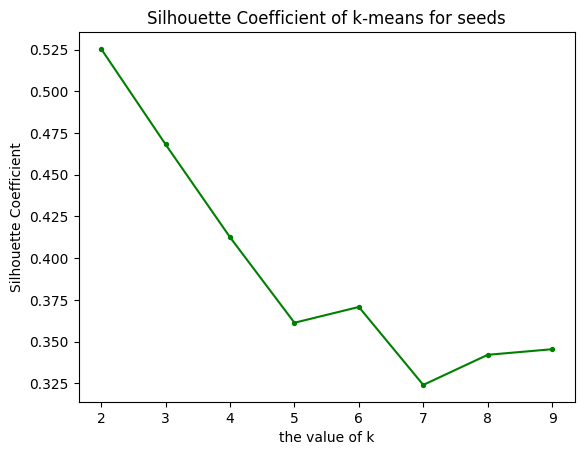

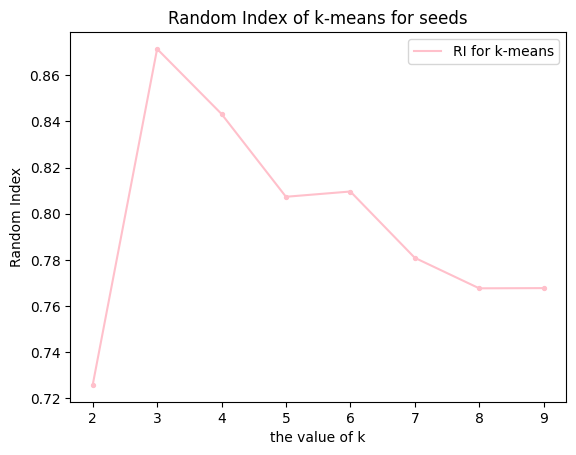

In [82]:
x = np.array(range(2,10))
figure1,ax1 = plt.subplots()
plt.title('Silhouette Coefficient of k-means for seeds')
figure2,ax2 = plt.subplots()
plt.title('Random Index of k-means for seeds')


# use green to plot the sc of kmeans
ax1.scatter(x,sc_kmeans,s=8,color = 'green')
ax1.plot(x,sc_kmeans,color="green", linestyle = 'solid', label='SC for k-means')

# use pink to plot the ri of kmeans
ax2.scatter(x,ri_kmeans,s=8,color='pink')
ax2.plot(x,ri_kmeans,color='pink',linestyle = 'solid', label='RI for k-means')

ax1.set_xlabel('the value of k')
ax1.set_ylabel('Silhouette Coefficient')
ax2.set_xlabel('the value of k')
ax2.set_ylabel('Random Index')
plt.legend()
plt.show()

#### plotting metrics for GMM

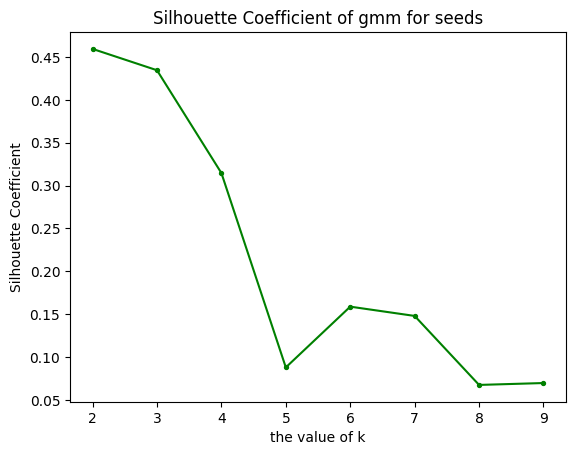

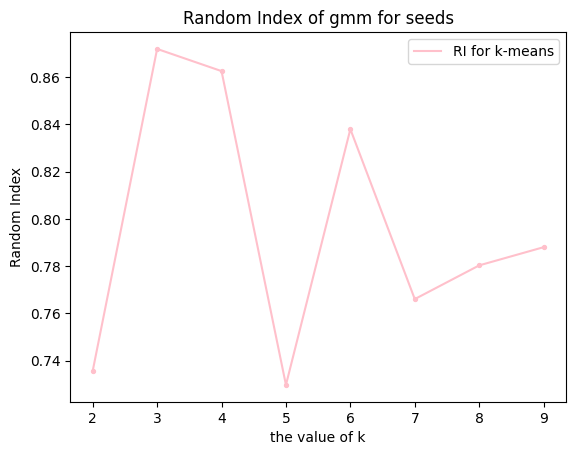

In [83]:
x = np.array(range(2,10))
figure1,ax1 = plt.subplots()
plt.title('Silhouette Coefficient of gmm for seeds')
figure2,ax2 = plt.subplots()
plt.title('Random Index of gmm for seeds')


# use pink to plot the sc of gmm
ax1.scatter(x,sc_gmm,s=8,color = 'green')
ax1.plot(x,sc_gmm,color="green", linestyle = 'solid', label='SC for k-means')

# use pink to plot the ri of gmm
ax2.scatter(x,ri_gmm,s=8,color='pink')
ax2.plot(x,ri_gmm,color='pink',linestyle = 'solid', label='RI for k-means')

ax1.set_xlabel('the value of k')
ax1.set_ylabel('Silhouette Coefficient')
ax2.set_xlabel('the value of k')
ax2.set_ylabel('Random Index')
plt.legend()
plt.show()

#### calculating best nmi

we can find that: <br />
best k for Silhouette Coefficient of kmeans is 2<br />
best k for Random Index of kmeans is 3<br />
best k for Silhouette Coefficient of GMM is 2<br />
best k for Random Index of GMM is 3<br />

In [85]:
nmi_sc_kmeans = calculate_nmi(label_kmeans[0],Y)
nmi_ri_kmeans = calculate_nmi(label_kmeans[1],Y)
nmi_sc_gmm = calculate_nmi(label_gmm[0],Y)
nmi_ri_gmm = calculate_nmi(label_gmm[1],Y)
print('nmi of best kmeans model found by sc: '+str(nmi_sc_kmeans))
print('nmi of best kmeans model found by ri: '+str(nmi_ri_kmeans))
print('nmi of best gmm model found by sc: '+str(nmi_sc_gmm))
print('nmi of best gmm model found by ri: '+str(nmi_ri_gmm))

nmi of best kmeans model found by sc: 0.5514899572480163
nmi of best kmeans model found by ri: 0.7100683008832275
nmi of best gmm model found by sc: 0.5717595817086311
nmi of best gmm model found by ri: 0.6685032617053913


### Vowel

#### get the data

In [86]:
x_Matrix = pd.read_csv('vowel.csv')
x_Matrix = np.array(x_Matrix)
Y = x_Matrix[:,-1:].flatten()
y_dic = {}
count = 0
for i in range(0,len(Y)):
    if Y[i] not in y_dic:
        y_dic[Y[i]] = count
        Y[i] = count
        count+=1
    else:
        Y[i] = y_dic[Y[i]]
Y = np.array(Y)
x_Matrix = x_Matrix[:,:-1] + 1e-7
x_Matrix = x_Matrix.astype('float')

#### find out metrics with clusttering center ranging from 10 to 19

In [87]:
label_kmeans = []
label_gmm = []
sc_kmeans = []
sc_gmm    = []
ri_kmeans = []
ri_gmm    = []
for z in range(10,20):
    labels, centroids = kmeans(x_Matrix, k=z)
    label_kmeans.append(labels)
    sc1 = silhouette_coefficient(labels,x_Matrix)
    ri1 = rand_index(labels, Y)
    sc_kmeans.append(sc1)
    ri_kmeans.append(ri1)

C:\Users\黄嘉赫\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [88]:
for z in range(10,20):
    labels, means, covariances, weights = gmm(x_Matrix, z)
    label_gmm.append(labels)
    sc2 = silhouette_coefficient(labels,x_Matrix)
    ri2 = rand_index(labels, Y)
    sc_gmm.append(sc2)
    ri_gmm.append(ri2)

C:\Users\黄嘉赫\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


#### plotting metrics for k-means

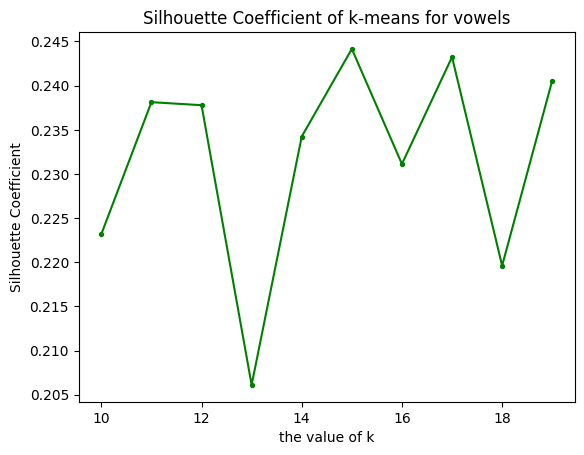

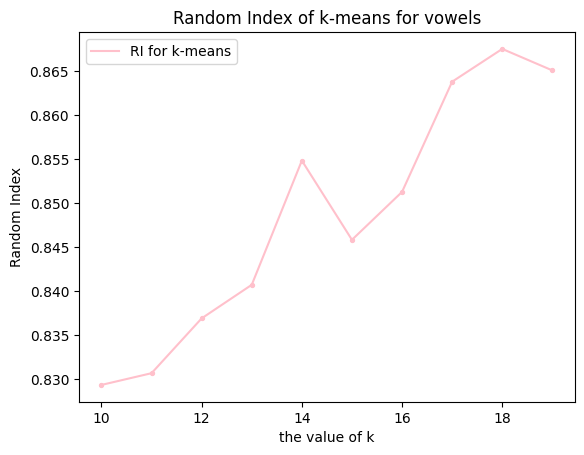

In [89]:
x = np.array(range(10,20))
figure1,ax1 = plt.subplots()
plt.title('Silhouette Coefficient of k-means for vowels')
figure2,ax2 = plt.subplots()
plt.title('Random Index of k-means for vowels')


# use green to plot the sc of kmeans
ax1.scatter(x,sc_kmeans,s=8,color = 'green')
ax1.plot(x,sc_kmeans,color="green", linestyle = 'solid', label='SC for k-means')

# use pink to plot the ri of kmeans
ax2.scatter(x,ri_kmeans,s=8,color='pink')
ax2.plot(x,ri_kmeans,color='pink',linestyle = 'solid', label='RI for k-means')

ax1.set_xlabel('the value of k')
ax1.set_ylabel('Silhouette Coefficient')
ax2.set_xlabel('the value of k')
ax2.set_ylabel('Random Index')
plt.legend()
plt.show()

#### plotting metrics for GMM

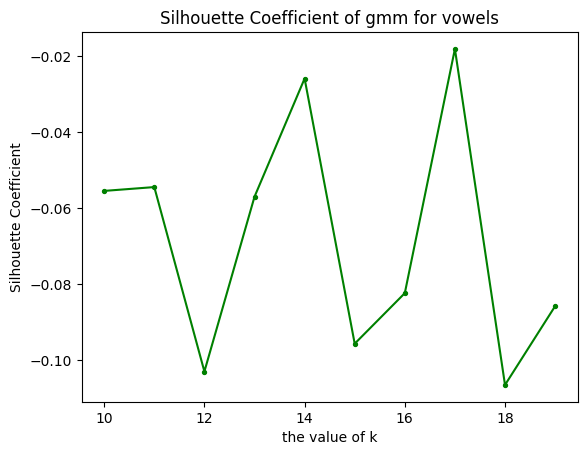

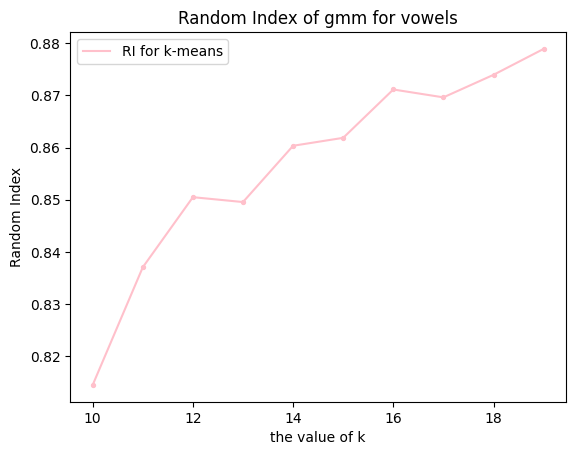

In [90]:
x = np.array(range(10,20))
figure1,ax1 = plt.subplots()
plt.title('Silhouette Coefficient of gmm for vowels')
figure2,ax2 = plt.subplots()
plt.title('Random Index of gmm for vowels')


# use green to plot the sc of gmm
ax1.scatter(x,sc_gmm,s=8,color = 'green')
ax1.plot(x,sc_gmm,color="green", linestyle = 'solid', label='SC for k-means')

# use pink to plot the ri of gmm
ax2.scatter(x,ri_gmm,s=8,color='pink')
ax2.plot(x,ri_gmm,color='pink',linestyle = 'solid', label='RI for k-means')

ax1.set_xlabel('the value of k')
ax1.set_ylabel('Silhouette Coefficient')
ax2.set_xlabel('the value of k')
ax2.set_ylabel('Random Index')
plt.legend()
plt.show()

#### calculating best nmi

we can find that: <br />
best k for Silhouette Coefficient of kmeans is 15<br />
best k for Random Index of kmeans is 18<br />
best k for Silhouette Coefficient of GMM is 17<br />
best k for Random Index of GMM is 19<br />

In [91]:
nmi_sc_kmeans = calculate_nmi(label_kmeans[5],Y)
nmi_ri_kmeans = calculate_nmi(label_kmeans[8],Y)
nmi_sc_gmm = calculate_nmi(label_gmm[7],Y)
nmi_ri_gmm = calculate_nmi(label_gmm[9],Y)
print('nmi of best kmeans model found by sc: '+str(nmi_sc_kmeans))
print('nmi of best kmeans model found by ri: '+str(nmi_ri_kmeans))
print('nmi of best gmm model found by sc: '+str(nmi_sc_gmm))
print('nmi of best gmm model found by ri: '+str(nmi_ri_gmm))

nmi of best kmeans model found by sc: 0.18484355110053674
nmi of best kmeans model found by ri: 0.26464876999701037
nmi of best gmm model found by sc: 0.3072633722444779
nmi of best gmm model found by ri: 0.3120806603249001
